Have you ever wondered a scenario where you have get thousands of documents and you are asked to identify on topics are these documents based. Ofcourse one of the solution is reading all those documents and coming up the topics. Another way to solve this problem is to ask your machine do it for you. Here comes the use case of Topic Modelling
Today we will be talking about steps required for topic modelling.

## Table of content:
    1)  Introduction
    2)  Import library
    3)  Load dataset
    4)  Preprocessing:
            Removing Special Characters
            Tokenization
            Removal of Stop words
            Lemmatization
    5)  Bringing the text into gensim acceptable format
    6)  Creating Dictionary of all unique words
    7)  Fitting the data to LDA model

Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics. This tutorial attempts to tackle both of these problems.

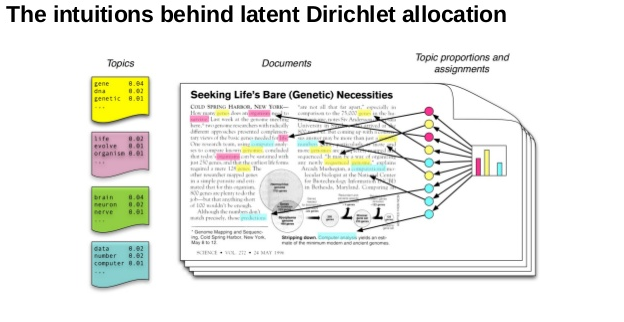

In [1]:
from IPython.display import Image
Image("/topic modelling.png")

## Introduction

One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.

In this tutorial, we will take a real example of the ’20 Newsgroups’ dataset and use LDA to extract the naturally discussed topics.

I will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

Let’s begin!
(We will be using CPU for this task. Please feel free to use your GPUs for faster performance.)

## Importing Neccessary Libraries

In [2]:
import pandas as pd
import re
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
from gensim.models.ldamodel import LdaModel,CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

## Reading data from internet in JSON format

In [3]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

In [4]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


Using regular expressions to clean the text. He the first function which we are using is the remove all the email ids present in the text. The next function (only_words) is used to extract only the characters from the text and remove all other special characters. More information on regular expressions can be found [here](https://www.guru99.com/python-regular-expressions-complete-tutorial.html)

In [5]:
def removing_email(text):
    text = re.sub('\S*@\S*\s',' ',text)
    return text
def only_words(text):
    text = re.sub('\W+',' ',text)
    return text

<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \W
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \W
<ipython-input-5-237a9ef13a09>:2: DeprecationWarning: invalid escape sequence \S
  text = re.sub('\S*@\S*\s',' ',text)
<ipython-input-5-237a9ef13a09>:5: DeprecationWarning: invalid escape sequence \W
  text = re.sub('\W+',' ',text)


Here we are just defining the list of stopwords which are to be removed from the text. Stop words are the words which are most common in any language. They mostly comprise of articles (a,an,the), prepostions etc. I have also added punctions, and few characters which are additional in the text are unwanted. These characters are already removed in the only_words function. But this is another way to remove some characters which are not present in the stop words present in NLTK. In the second line we intitalize the Lemmatization object. Lemmatization is basically done the bring done a word into its base form. Eg. Smoker, Smoking, Smokes becomes smoke. This step is important as it reduces the vocabulary size and also these all words are with respect to same context that is related to smoking.

In [6]:
stop_words = list(set(stopwords.words('english')))+list(punctuation)+['\n','----','----\n\n\n\n\n']
lem = WordNetLemmatizer()

This is the main function used for cleaning for the text. First we convert the text into lowercase because the stop words defined are in NLTK are in lower case. So if this step is not done then they won't be removed. Word tokenization is done to break the sentence into individual words as each becomes an element of the list. After which we create a list of only those words which are not present in the stopwords list. Then we keep only those words that have len more than or equal to 3. This makes sense as 2 letter words don't give us any information in most of the cases. (This is an optional step you can skip this if you want). Final step is to perform lemmatization. 'v' stands for verb that is smoking becomes smoke. Finally we return the list of clean text.

In [7]:
def cleaning(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    words = [w for w in words if len(w)>=3]
    lemma = [lem.lemmatize(w,'v') for w in words]
    return lemma

Applying all the functions to the text and creating a new column each time so that you can see the difference. This is only for demonstration. Please clean the same column if you have memory issues.

In [8]:
df['without email'] = df['content'].apply(removing_email)
df['only words'] = df['without email'].apply(only_words)
df['clean content'] = df['only words'].apply(cleaning)

In [9]:
 df.head()

,content,target,target_names,without email,only words,clean content
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,From: (where's my thing)\nSubject: WHAT car i...,From where s my thing Subject WHAT car is this...,"[thing, subject, car, nntp, post, host, rac3, ..."
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,From: (Guy Kuo)\nSubject: SI Clock Poll - Fin...,From Guy Kuo Subject SI Clock Poll Final Call ...,"[guy, kuo, subject, clock, poll, final, call, ..."
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles,From: (Irwin Arnstein)\nSubject: Re: Recommen...,From Irwin Arnstein Subject Re Recommendation ...,"[irwin, arnstein, subject, recommendation, duc..."
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale,From: (Tsung-Kun Chen)\nSubject: ** Software ...,From Tsung Kun Chen Subject Software forsale l...,"[tsung, kun, chen, subject, software, forsale,..."
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc,From: (Don A.B. Lindbergh)\nSubject: Diamond ...,From Don A B Lindbergh Subject Diamond SS24X W...,"[lindbergh, subject, diamond, ss24x, win, mous..."


Clean docs is a list of all the text observations in a list format. It is a nested list with the list of words of first observation as the first element of the clean_doc list and second observation words list as the second element of the clean_doc list. Something like this [ [thing, subject, car, nntp, post, host,........] , [guy, kuo,subject, clock, poll,....],[...]]

In [10]:
clean_doc = list(df['clean content'].values)

Here we create a dictionary of words that is each unique word is assigned a unique number with which it will represented from now on.

In [11]:
dictionary = Dictionary(clean_doc)

Corpus is whole text where each word is replaces with its corresponding integer. (bow stands for bag of words)

In [12]:
corpus = [dictionary.doc2bow(doc) for doc in clean_doc]

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

Chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

These all are hyperparameters which can be tuned in order to improve you model.

Detailed math can be found [here](https://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/)

In [13]:
ldamodel = LdaModel(corpus=corpus,id2word=dictionary,num_topics=5,random_state=42,update_every=1,passes=50, chunksize=100)

Here we can see that the words and topics in the sentence. First topic is something related to people, state , government, gun
Second topic is something about organisation, game, key, team, article and so on. Numbers next to the words represent the weights and give the importance of the weights.

In [14]:
print(ldamodel.print_topics())

[(0, '0.015*"use" + 0.008*"file" + 0.008*"card" + 0.007*"windows" + 0.006*"line" + 0.006*"program" + 0.006*"drive" + 0.006*"system" + 0.006*"key" + 0.005*"chip"'), (1, '0.009*"say" + 0.008*"would" + 0.008*"people" + 0.007*"one" + 0.005*"write" + 0.005*"know" + 0.005*"think" + 0.005*"make" + 0.005*"god" + 0.004*"jesus"'), (2, '0.115*"max" + 0.055*"g9v" + 0.014*"b8f" + 0.012*"a86" + 0.008*"bhj" + 0.008*"1d9" + 0.006*"giz" + 0.006*"2tm" + 0.005*"75u" + 0.005*"7ey"'), (3, '0.014*"line" + 0.013*"subject" + 0.013*"organization" + 0.009*"post" + 0.009*"write" + 0.008*"article" + 0.008*"get" + 0.007*"would" + 0.007*"one" + 0.007*"university"'), (4, '0.013*"game" + 0.013*"team" + 0.009*"year" + 0.008*"play" + 0.008*"win" + 0.008*"hockey" + 0.006*"league" + 0.006*"season" + 0.005*"nhl" + 0.004*"players"')]


Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [15]:
print(ldamodel.log_perplexity(corpus))

-8.853419445584228


For detailed information on Coherence Score and Math behind it please refer this [research paper](https://www.aclweb.org/anthology/D12-1087)

In [16]:
coherence = CoherenceModel(ldamodel,texts=clean_doc,dictionary=dictionary,coherence='c_v')

In [17]:
coherence.get_coherence()

0.6957094706807365

In [20]:
coherence = CoherenceModel(ldamodel,texts=clean_doc,dictionary=dictionary,coherence='u_mass')

In [21]:
coherence.get_coherence()

-1.3355817376294212

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

C:\Users\Samarth\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.197161 -0.025674       1        1  39.905495
1      0.190427 -0.048966       2        1  33.149307
0      0.105936  0.165118       3        1  16.284307
4     -0.188289 -0.262705       4        1   7.634703
2     -0.305236  0.172227       5        1   3.026186, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
4024   Default   6090.000000           max   6090.000000  30.0000  30.0000
25022  Default   2925.000000           g9v   2925.000000  29.0000  29.0000
368    Default   9884.000000           use   9884.000000  28.0000  28.0000
2964   Default   1773.000000          game   1773.000000  27.0000  27.0000
824    Default   2408.000000          file   2408.000000  26.0000  26.0000
650    Default   1696.000000          team   1696.000000  25.0000  25.0000
70     Default   2498.000000          card   2498.000000  24.0000  24.0000
375    Default   2185.000000          year   2185.000000  23.0000  23.0000
249    Default   2094.000000       windows   2094.000000  22.0000  22.0000
352    Default   7394.000000           say   7394.000000  21.0000  21.0000
479    Default   5325.000000        people   5325.000000  20.0000  20.0000
530    Default   2856.000000           god   2856.000000  19.0000  19.0000
310    Default   2706.000000         drive   2706.000000  18.0000  18.0000
609    Default   1320.000000          play   1320.000000  17.0000  17.0000
433    Default   2109.000000       program   2109.000000  16.0000  16.0000
65     Default   7768.000000       article   7768.000000  15.0000  15.0000
35     Default   4752.000000          nntp   4752.000000  14.0000  14.0000
843    Default   2028.000000           key   2028.000000  13.0000  13.0000
1122   Default   2471.000000         jesus   2471.000000  12.0000  12.0000
277    Default   1206.000000           win   1206.000000  11.0000  11.0000
2769   Default   1768.000000          chip   1768.000000  10.0000  10.0000
22     Default   5014.000000          host   5014.000000   9.0000   9.0000
752    Default   1012.000000        hockey   1012.000000   8.0000   8.0000
39     Default   7713.000000          post   7713.000000   7.0000   7.0000
24819  Default    734.000000           b8f    734.000000   6.0000   6.0000
240    Default   2776.000000        system   2776.000000   5.0000   5.0000
163    Default   2779.000000           run   2779.000000   4.0000   4.0000
9430   Default    651.000000           a86    651.000000   3.0000   3.0000
27     Default  13227.000000          line  13227.000000   2.0000   2.0000
36     Default  11395.000000  organization  11395.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
24819   Topic5    734.169189           b8f    734.973267   3.4968  -4.2811
9430    Topic5    650.845276           a86    651.649353   3.4966  -4.4015
9511    Topic5    438.355621           bhj    439.159729   3.4960  -4.7968
9022    Topic5    401.209900           1d9    402.014099   3.4959  -4.8853
33963   Topic5    338.178558           giz    338.982666   3.4955  -5.0562
33688   Topic5    314.616882           2tm    315.420990   3.4953  -5.1284
24565   Topic5    285.998199           75u    286.802307   3.4951  -5.2238
24576   Topic5    268.408020           7ey    269.212128   3.4949  -5.2873
24282   Topic5    226.590439           2di    227.394547   3.4943  -5.4567
52458   Topic5    217.194061          mg9v    217.998169   3.4942  -5.4990
9107    Topic5    182.138992           34u    182.943100   3.4935  -5.6750
34128   Topic5    157.600494           qax    158.404602   3.4928  -5.8197
34083   Topic5    146.059341          nrhj    146.863449   3.4924  -5.8958
33859   Topic5    138.428802           b4q    139.232910   3.4921  -5.9494
33864   Topic5    137.388336           biz    138.1943

#### Current Issues in topic Modelling:
The models are very sensitive to the input data small changes to the stemming/tokenisation algorithms can result in completely different topics; topics need to be manually categorised in order to be useful (often arbitrarily, as the topics often contain mixed content); topics are "unstable" in the sense that adding new documents can cause significant changes to the topic distribution (less of an issue with large corpi). Solution to this problem is still an area of research.

I used topic modeling techniques for compact document topic representation. In this application, the topic identification (and modeling) is used as a data compression technique: identifies the rough category and allows the selection of topic-dependent, finer classifications. In this sense, the topics are a characteristic of the corpus and their changes reflect changes in the requirements. This is not necessarily bad. Of course if you want to recognize topics as we, humans consider them, you need classification and supervised learning with annotated teaching data sets. If you use unsupervised approach, generated topics may not exactly overlap with our original topics. Summarized, I think topic models are very useful in many aspects, but if you do not want to see shifts in topic boundaries, you need supervised learning techniqes. Otherwise, the system may draw borders where it is less expected.

Topic models are good for data exploration, when there is some new data set and you don't know what kinds of structures that you could possibly find in there. But if you did know what structures you could find in your data set, topic models are still useful if you didn't have the time or resources to construct classification models based on supervised machine learning. Lastly, if you did have the time and resources to construct classification models based on supervised learning, topic models would still be useful as extra features to add to the models in order to increase their accuracy. This is the case because topic models act as a kind of "smoothing" that helps combat the sparse data problem that is often seen in supervised learning.

There are several other techniques which can be used for topic modelling like NMF and SVD. These are available in sklearn. We can use LDA in sklearn as well but Gensim is more powerful and also provides weights for each word telling the importance of that word.

#### Applications of Topic Modelling:

People are using Topic Modelling in Marketing. They take all the reviews of the customer and extract what are the important topics on which people are talking about their service/product. Also when people recieve tons of emails everyday about a particular conversation. Nobody is having enough to go through all the emails and analyse what is the converstation about. He can just perform topic modelling and extract different topics and come up with a conclusion.

#### Future Scope:
You can check out more on Semi Supervised LDA [here](https://www.freecodecamp.org/news/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164/)

### This tutorial is intended to be a public resource. As such, if you see any glaring inaccuracies or if a critical topic is missing, please feel free to point it out or (preferably) submit a pull request to improve the tutorial. Also, we are always looking to improve the scope of this article. For anything feel free to mail us @ colearninglounge@gmail.com
### Credits
### The author of this article is Samarth Sarin You can follow him on [LinkedIn](https://www.linkedin.com/in/samarthsarin), [Kaggle](https://kaggle.com/samarthsarin).